# Bitcoin Price. Prediction by ARIMA

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

ModuleNotFoundError: No module named 'statsmodels'

## Data Exploration

In [ ]:
# Load data
df = pd.read_csv('btceUSD_1-min_data_2012-01-01_to_2017-05-31')
df.head()

NameError: name 'pd' is not defined

In [ ]:
# Unix-time to 
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')

# Resampling to daily frequency
df.index = df.Timestamp
df = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

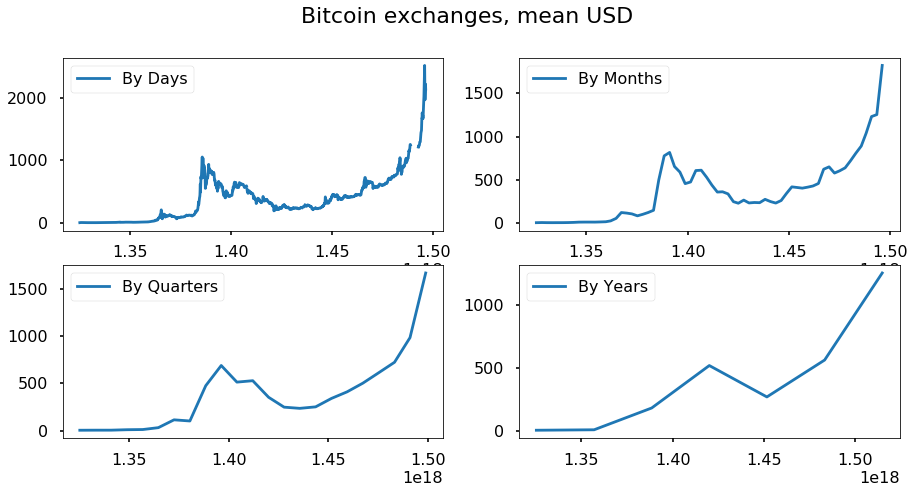

In [ ]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.Weighted_Price, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Weighted_Price, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.Weighted_Price, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Weighted_Price, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

I will predict bitcoin prices by months.

## Stationarity check and STL-decomposition of the series

Dickey–Fuller test: p=0.997760


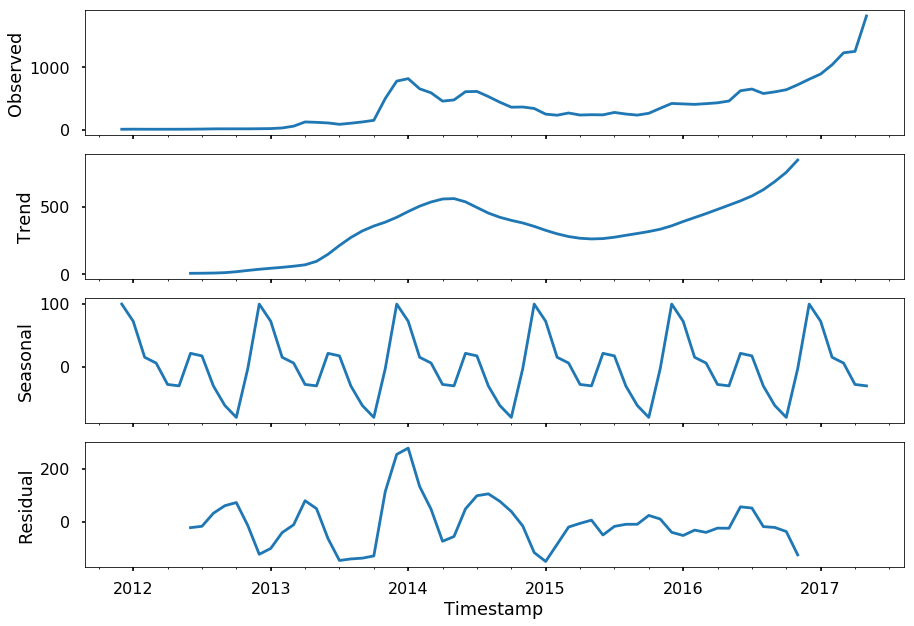

In [ ]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.Weighted_Price).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])
plt.show()

The series are not stationary.

## Box-Cox Transformations

In [ ]:
# Box-Cox Transformations
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.Weighted_Price)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])

Dickey–Fuller test: p=0.997760


The series are not stationary.

## Seasonal differentiation

In [ ]:
# Seasonal differentiation
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.137240


The series are not stationary.

## Regular differentiation

Dickey–Fuller test: p=0.014538


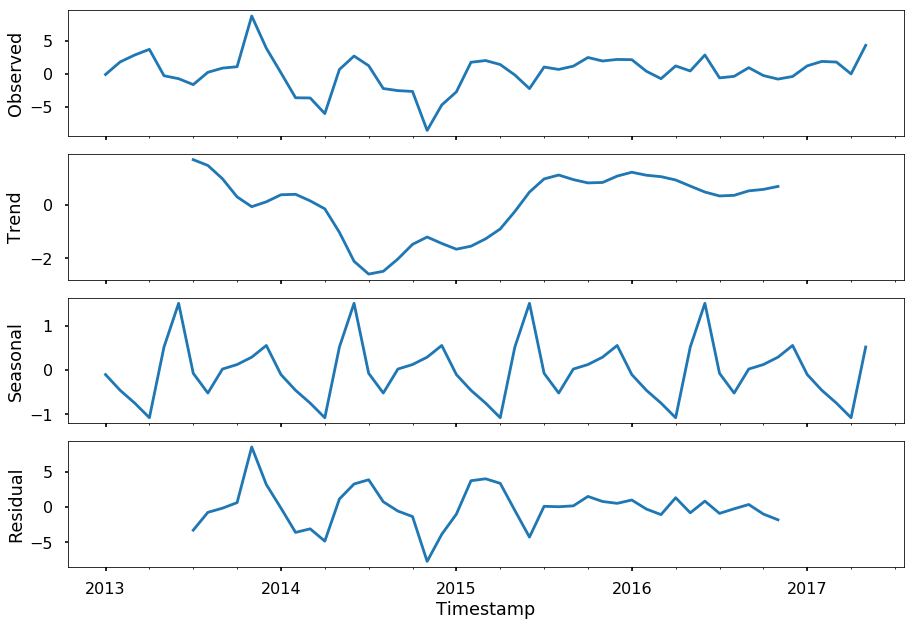

In [ ]:
# Regular differentiation
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

The series are stationary.

## Model Selection

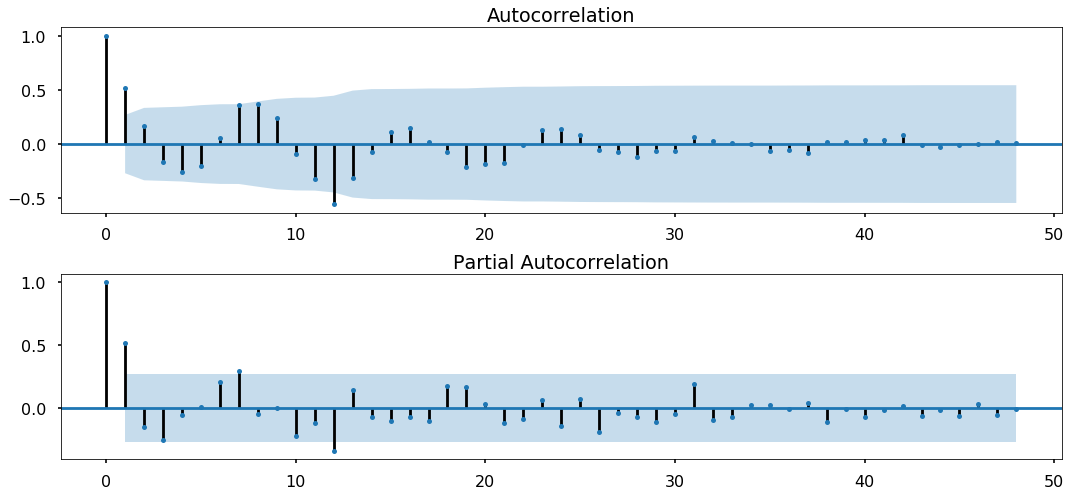

In [ ]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [ ]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

wrong parameters: (0, 0, 0, 0)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 0, 1)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 1, 1, 1)
wrong parameters: (2, 1, 2, 0)
wrong parameters: (2, 1, 2, 1)


In [ ]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
21  (1, 0, 2, 0)  220.331987
20  (1, 0, 1, 1)  220.386077
18  (1, 0, 0, 1)  220.741648
19  (1, 0, 1, 0)  221.262547
12  (0, 2, 0, 1)  221.834795
                                 Statespace Model Results                                 
Dep. Variable:                 Weighted_Price_box   No. Observations:                   66
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -106.166
Date:                            Tue, 14 Nov 2017   AIC                            220.332
Time:                                    10:17:07   BIC                            229.091
Sample:                                12-31-2011   HQIC                           223.793
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

## Analysis of residues

Dickey–Fuller test:: p=0.000000


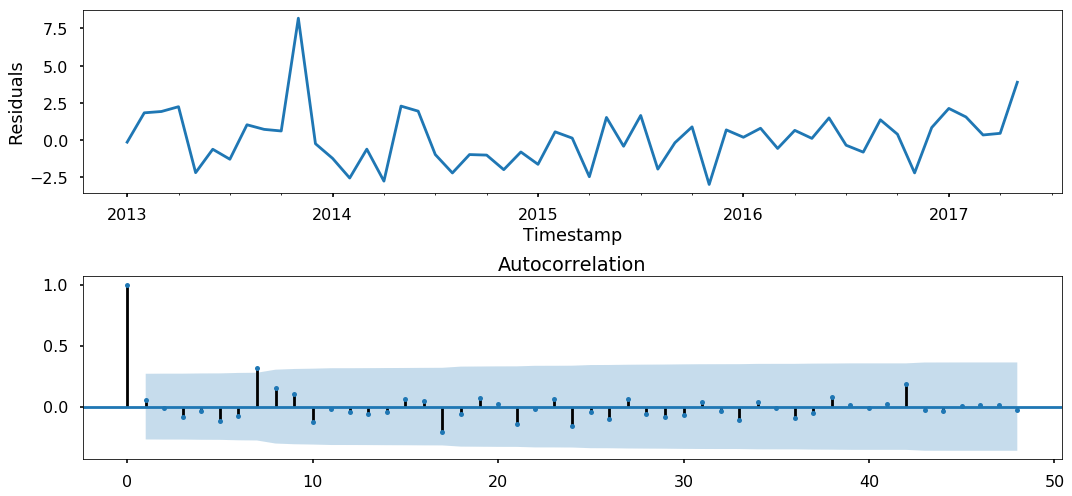

In [ ]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

It`s OK.

## Prediction

In [ ]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

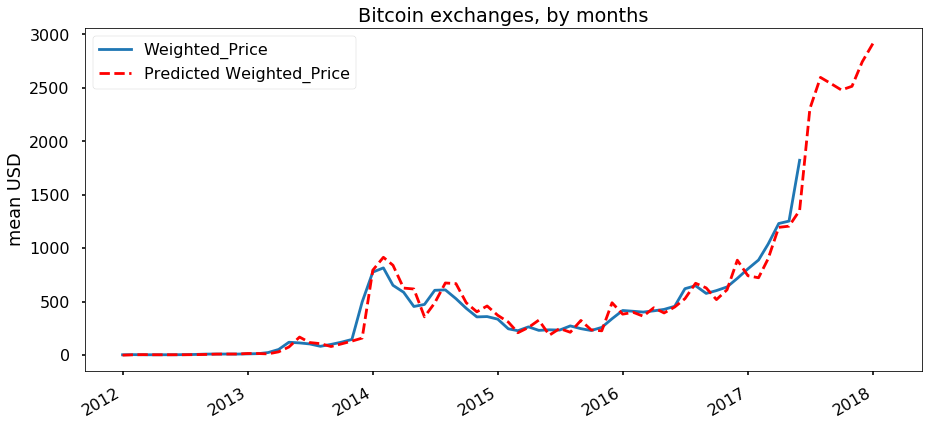

In [ ]:
# Prediction
df_month2 = df_month[['Weighted_Price']]
date_list = [datetime(2017, 6, 30), datetime(2017, 7, 31), datetime(2017, 8, 31), datetime(2017, 9, 30), 
             datetime(2017, 10, 31), datetime(2017, 11, 30), datetime(2017, 12, 31), datetime(2018, 1, 31),
             datetime(2018, 1, 28)]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)
plt.figure(figsize=(15,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()